# In-class work 1: Introduction to training neural networks

Okay, now that we've covered some data science basics, let's get a very baseline neural network training pipeline going. 

**Important:** Make sure this notebook is pointing toward your custom `conda` kernel (top right drop-down menu).

In [ ]:
# wandb setup:
import wandb
wandb.login()

wandb: Currently logged in as: roycruzcan (roycruzcan-university-of-wisconsin-madison) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

<a name='section_0'></a>
<h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #1f77b4">0. Installing pytorch</h2>

In [2]:
### test that torch will work 

import torch

x = torch.rand(5, 3)
print(x)

tensor([[0.6212, 0.5264, 0.5396],
        [0.4081, 0.7583, 0.4141],
        [0.2401, 0.9054, 0.0854],
        [0.1820, 0.4691, 0.2444],
        [0.1772, 0.4084, 0.6666]])


Here's a full cell of imports. What's a good resolution we can use for plotting? Refer to the previous in-class notebook if you can't remember, and fill it in here:

In [3]:
### here's the full cell of imports 

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

### set plot resolution
%config InlineBackend.figure_format = "retina" # <<<<<<<<<<<< INSERT CODE HERE

### set default figure parameters
plt.rcParams['figure.figsize'] = (9,6)

medium_size = 12
large_size = 15

plt.rc('font', size=medium_size)          # default text sizes
plt.rc('xtick', labelsize=medium_size)    # xtick labels
plt.rc('ytick', labelsize=medium_size)    # ytick labels
plt.rc('legend', fontsize=medium_size)    # legend
plt.rc('axes', titlesize=large_size)      # axes title
plt.rc('axes', labelsize=large_size)      # x and y labels
plt.rc('figure', titlesize=large_size)    # figure title

<a name='section_1'></a>
<h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #1f77b4">1. Generating a dataset</h2>

First, we'll generate one of the simplest toy datasets there is: two Gaussian distributions. Let's say that they describe our signal and our background events, but that there are only 2 parameters we can measure ($\theta_1$ and $\theta_2$).

In [4]:
### Two 2D Gaussian distributions with the same number of events
n_events = 4000

### Background is sampled from N(mu0, Sigma0)
mu0 = np.array([-1.0, -1.0])
cov0 = np.array([[1.0, 0.2],
                 [0.2, 1.2]])
x0 = np.random.multivariate_normal(mu0, cov0, size=n_events)
y0 = np.zeros((n_events, 1), dtype=np.float32) # 0 labels

### Signal is sampled from N(mu1, Sigma1)
mu1 = np.array([1.0, 1.0])
cov1 = np.array([[1.3, -0.3],
                 [-0.3, 0.8]])
x1 = np.random.multivariate_normal(mu1, cov1, size=n_events)
y1 = np.ones((n_events, 1), dtype=np.float32) # 1 labels

X = np.vstack([x0, x1]).astype(np.float32)
y = np.vstack([y0, y1]).astype(np.float32)

### Put these together and shuffle
idx = np.random.permutation(len(X))
X = X[idx] # inputs
y = y[idx] # labels

print("Data shapes:", X.shape, y.shape)

Data shapes: (8000, 2) (8000, 1)


Let's put it into a Pandas dataframe for legibility:

In [5]:
df = pd.DataFrame(np.hstack([X,y]), columns = ["theta_1", "theta_2", "label"])

In [6]:
df

,theta_1,theta_2,label
0,-1.407495,-1.620488,0.0
1,-1.471974,0.591274,0.0
2,0.442228,1.743000,1.0
3,-0.681253,0.537203,1.0
4,-1.202469,-1.092696,0.0
...,...,...,...
7995,-0.904371,-0.723982,0.0
7996,-1.985256,0.078634,0.0
7997,-0.616786,0.364805,1.0
7998,-0.753169,0.816485,1.0


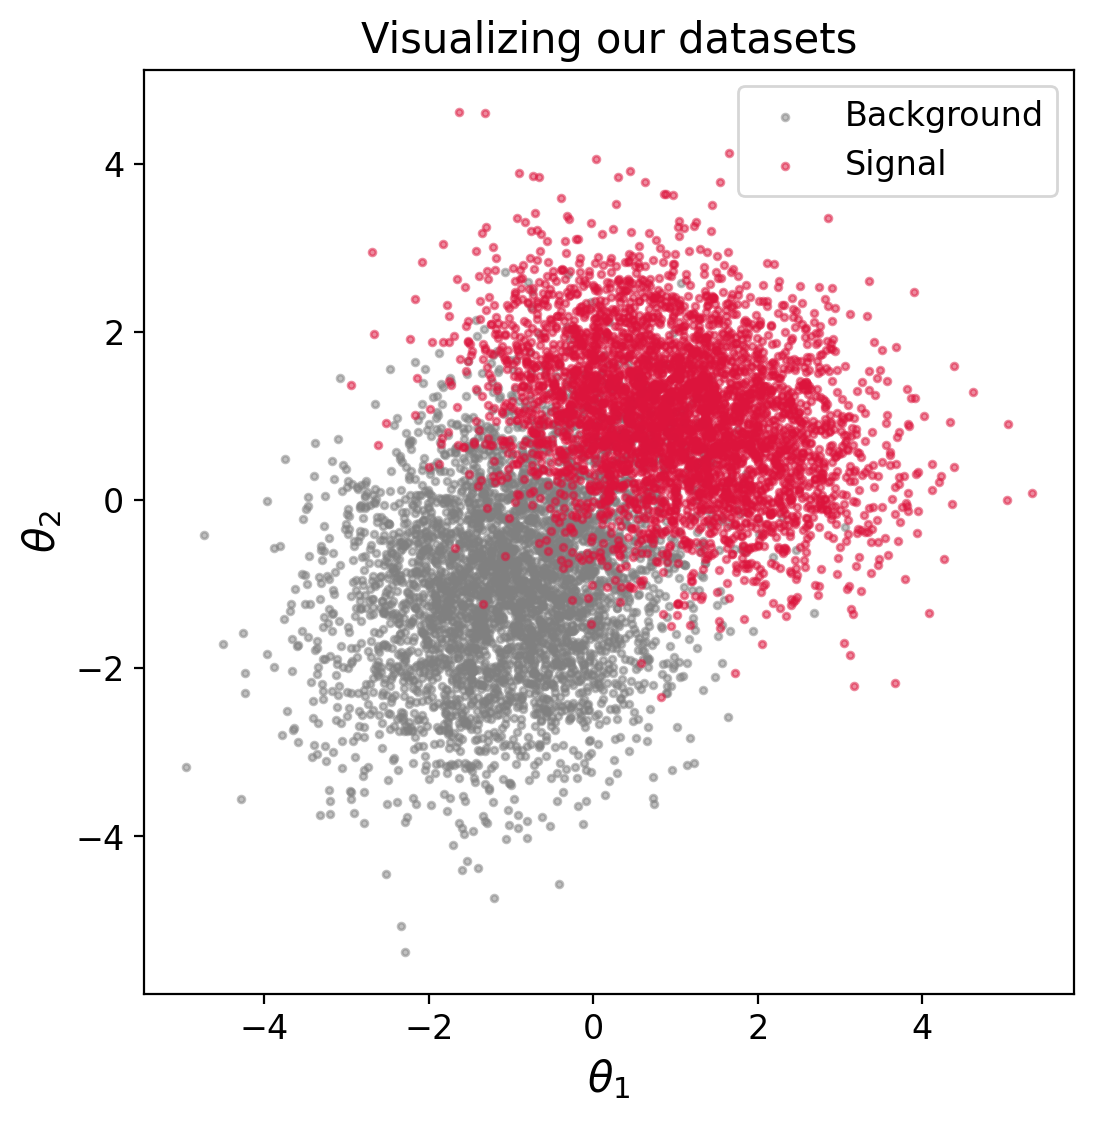

In [7]:
plt.figure(figsize=(6,6))
plt.scatter(df[df.label != True].theta_1, df[df.label != True].theta_2, s=6, color="grey", alpha=0.5, label="Background")
plt.scatter(df[df.label == True].theta_1, df[df.label == True].theta_2, s=6, color="crimson", alpha=0.5, label="Signal")
plt.legend()
plt.title("Visualizing our datasets")
plt.xlabel(r"$\theta_1$"); plt.ylabel(r"$\theta_2$")
plt.show()

<a name='section_2'></a>
<h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #1f77b4">2. Defining a neural network model</h2>

In [8]:
class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32, hidden_layers = 2): # <<<< FILL IN INPUT DIMENSION 
        super().__init__()
        # Number of linear hidden layers = hidden_layers
        layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU()]
        for _ in range(hidden_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1)) # add dropout with 10% probability
        layers += [nn.Linear(hidden_dim, 1)] # output is 1-dimensional for
        self.MLP = nn.Sequential(*layers)
    def forward(self, x):
        return self.MLP(x)

<a name='section_3'></a>
<h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #1f77b4">3. Preprocessing</h2>

Key steps include splitting into train/validation/test sets, standardizing data, and building dataloaders.

In [9]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["label"])  # only look at the features, not the labels
y = df["label"]                 # labels

### Take the first 70% for training
X_train, X_valtest, y_train, y_valtest = train_test_split( # train -> 70%, val -> 30% (the parameter you specify in train_test_split funct)
    X, y, test_size=0.3)

### Then evenly split the remaining 30% into validation & test set 
X_val, X_test, y_val, y_test = train_test_split(
    X_valtest, y_valtest, test_size=0.5
)

print(f"Train set has {len(X_train)} events.")
print(f"Validation set has {len(X_val)} events.")
print(f"Test set has {len(X_test)} events.")

Train set has 5600 events.
Validation set has 1200 events.
Test set has 1200 events.


You can standardize your data using a "z-score" manually by subtracting the mean and dividing by the standard deviation. 

Alternatively, you can use the StandardScaler plugin to do this automatically:

In [10]:
from sklearn.preprocessing import StandardScaler

### initialize the scaler
scaler = StandardScaler()

### IMPORTANT -- you only want to define your scaling ("fit_transform") based on your training dataset. ***
X_train_scaled = scaler.fit_transform(X_train)

### Now re-use the same transformation on validation & test sets ("transform")
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("Train mean (before scaling):", np.array(X_train.mean(axis=0)))
print("Train mean (after scaling) -- each dimension should be close to 0:", X_train_scaled.mean(axis=0))
print("Train std (before scaling)", np.array(X_train.std(axis=0)))
print("Train std (after scaling) -- each dimension should be close to 1:", X_train_scaled.std(axis=0))

Train mean (before scaling): [ 0.00331757 -0.00256115]
Train mean (after scaling) -- each dimension should be close to 0: [-7.0354766e-09 -2.0787120e-08]
Train std (before scaling) [1.4570756 1.4075326]
Train std (after scaling) -- each dimension should be close to 1: [0.99999994 0.9999992 ]


<a name='problem_x'></a> 
### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #1f77b4; color: #1f77b4;">Problem: Standardizing with z-scores </span>

Try implementing this standardization by hand, and check that your scaled distributions are close to the ones that you got using the StandardScaler.

In [11]:
X_train_stats = X_train.describe()
X_mean_1 = X_train_stats["theta_1"].loc["mean"]
X_std_1 = X_train_stats["theta_1"].loc["std"]
X_mean_2 = X_train_stats["theta_2"].loc["mean"]
X_std_2 = X_train_stats["theta_2"].loc["std"]

def scale_func(X):
    return np.array(
        pd.DataFrame(
            [
                (X["theta_1"] - X_mean_1) / X_std_1,
                (X["theta_2"] - X_mean_2) / X_std_2,
            ]
        ).T
    )

X_train_scaled_by_hand = scale_func(X_train)
X_val_scaled_by_hand = scale_func(X_val) 
X_test_scaled_by_hand = scale_func(X_test)

X_train_scaled_by_hand

array([[-0.7714991 , -1.2878124 ],
       [ 0.6257225 ,  0.33133617],
       [-0.86194676,  1.2436907 ],
       ...,
       [ 1.9337138 ,  0.5614654 ],
       [-1.7408121 , -0.8048176 ],
       [ 0.45464906, -0.90915096]], dtype=float32)

In [12]:
# Checking that the scaling by hand worked as expected
print("Train mean (before scaling):", np.array(X_train.mean(axis=0)))
print("Train mean (after scaling) -- each dimension should be close to 0:", X_train_scaled_by_hand.mean(axis=0))
print("Train std (before scaling)", np.array(X_train.std(axis=0)))
print("Train std (after scaling) -- each dimension should be close to 1:", X_train_scaled_by_hand.std(axis=0))

Train mean (before scaling): [ 0.00331757 -0.00256115]
Train mean (after scaling) -- each dimension should be close to 0: [ 4.8428772e-10 -2.3022293e-08]
Train std (before scaling) [1.4570756 1.4075326]
Train std (after scaling) -- each dimension should be close to 1: [0.9999094  0.99990976]


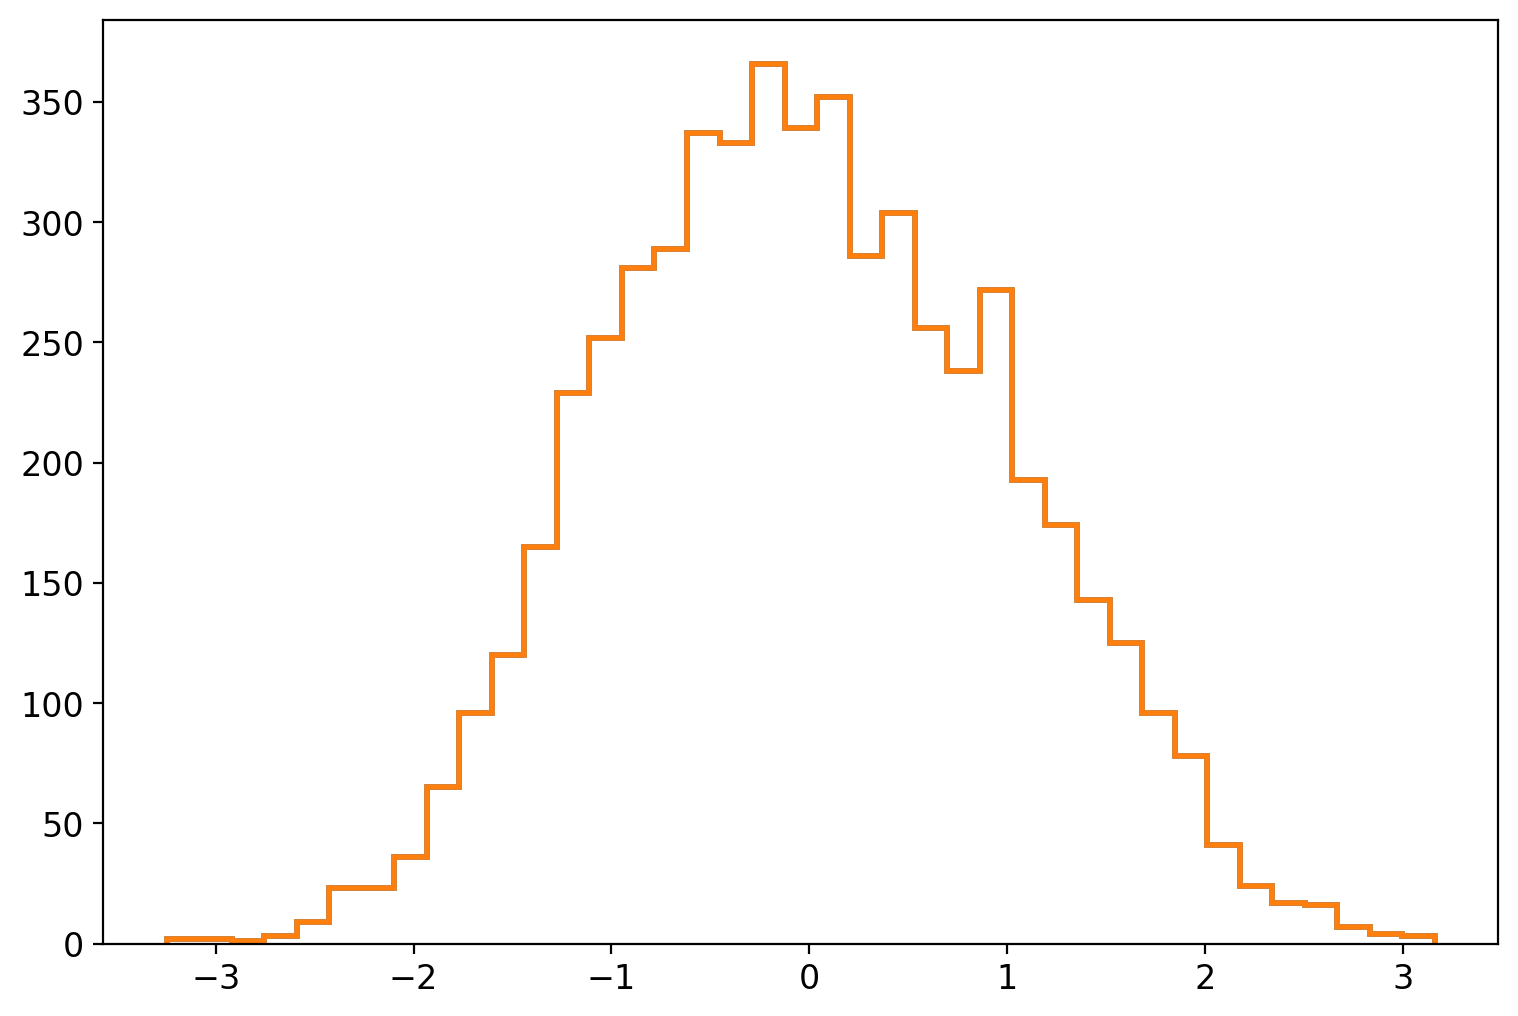

In [13]:
plt.figure()
bins = np.linspace(np.min([X_train_scaled[:,0], X_train_scaled_by_hand[:,0]]), np.max([X_train_scaled[:,0], X_train_scaled_by_hand[:,0]]), 40)
### theta_1
plt.hist(X_train_scaled[:,0], bins=bins, histtype="step", linewidth=2, label="$\theta_1$");
plt.hist(X_train_scaled_by_hand[:,0], bins=bins, histtype="step", linewidth=2, label="$\theta_1$ (by hand)");

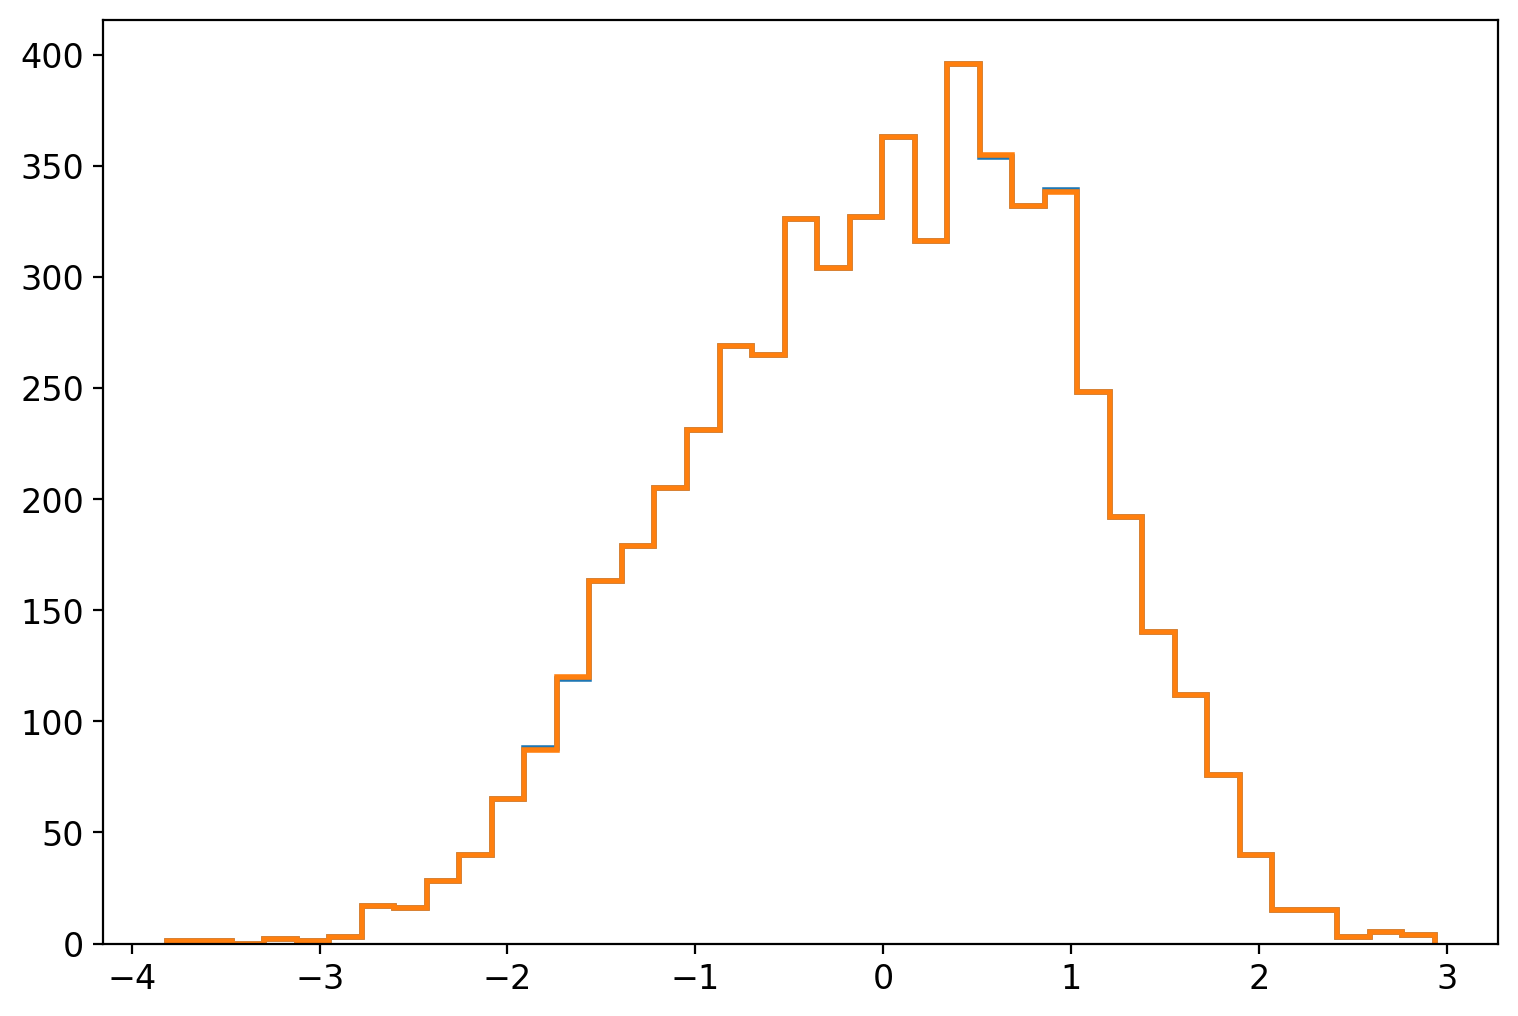

In [14]:
plt.figure()
bins = np.linspace(np.min([X_train_scaled[:,1], X_train_scaled_by_hand[:,1]]), np.max([X_train_scaled[:,1], X_train_scaled_by_hand[:,1]]), 40)
### theta_2
plt.hist(X_train_scaled[:,1], bins=bins, histtype="step", linewidth=2, label="$\theta_2$");
plt.hist(X_train_scaled_by_hand[:,1], bins=bins, histtype="step", linewidth=2, label="$\theta_2$ (by hand)");

In [15]:
### now we'll construct data loaders. we'll use 32 as our default batch size for now. 

batch_size = 128

train_ds = TensorDataset(torch.from_numpy(X_train_scaled), torch.from_numpy(y_train.values.astype("float32")).view(-1, 1)) # view ~> reshape, used to have tensor with shape (2800, 1)
val_ds   = TensorDataset(torch.from_numpy(X_val_scaled),   torch.from_numpy(y_val.values.astype("float32")).view(-1, 1))
test_ds  = TensorDataset(torch.from_numpy(X_test_scaled),  torch.from_numpy(y_test.values.astype("float32")).view(-1, 1))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

Test one of these loaders:

In [16]:
for x_batch, y_batch in train_loader:
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([128, 2]) torch.Size([128, 1])


<a name='section_4'></a>
<h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #1f77b4">4. Training</h2>

Let's play with tracking our model training using `livelossplot`.

In [17]:
from livelossplot import PlotLosses

In [ ]:
n_epochs = 100
hidden_dims = 16
hidden_layers = 3
lr = 0.0001

Single run training and logging in wandb

In [ ]:
def train(n_epochs, hidden_dims, hidden_layers, lr):
    run = wandb.init(
        project="phys805",
        name="intro_training_a_nn",
        config={
            "n_epochs": n_epochs,
            "hidden_dims": hidden_dims,
            "hidden_layers": hidden_layers,
            "lr": lr
        }
    )
        
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    ### Initialize the model, optimizer, and loss function -- what should the input dimensionality be?
    model = MLP(input_dim=2, hidden_dim=hidden_dims, hidden_layers=hidden_layers) #<<<<<<<< FILL IN HERE
    model = model.to(device) # move onto the GPU, if present
    loss_fn = nn.BCEWithLogitsLoss() # BCE = Binary Cross Entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=lr ) #<<<<<<<< FILL IN HERE -- what's the default learning rate for Adam? Answer: 0.001

    liveloss = PlotLosses(figsize=(9, 4)) 
    logs = {}

    ### Training loop
    for epoch in range(n_epochs):

        ### train
        # Set the model to training mode
        model.train()
        total_train_loss = 0
        # Iterate over the training DataLoader
        for x_batch, y_batch in train_loader:
            # Zero the gradients because by default they accumulate because
            optimizer.zero_grad()
            
            ### Move the batch onto the GPU, if present
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # Forward pass
            out = model(x_batch)
            # Compute loss
            loss = loss_fn(out, y_batch)
            # Backward pass
            loss.backward()
            # Update the weights after the gradients have been computed for this batch
            optimizer.step()
            # Accumulate the training loss
            total_train_loss += loss.item()

        # Average training loss over all batches in this epoch
        train_loss_per_batch = total_train_loss / len(train_loader)
        logs['loss'] = train_loss_per_batch

        ### validate
        # Set the model to evaluation mode
        model.eval()
        total_val_loss = 0
        # Iterate over the validation DataLoader
        for x_batch, y_batch in val_loader:
            
            ### Move the batch onto the GPU, if present
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # Forward pass
            out = model(x_batch)
            # Compute loss
            loss = loss_fn(out, y_batch)
            # Accumulate the validation loss
            total_val_loss += loss.item()

        # Average validation loss over all validation batches
        val_loss_per_batch = total_val_loss / len(val_loader)
        # Log the validation loss
        logs['val_loss'] = val_loss_per_batch

        # Update the liveloss plot
        liveloss.update(logs)
        liveloss.send()
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        wandb.log(
            {
                "loss": train_loss_per_batch, 
                "val_loss": val_loss_per_batch
            }
        )
        
    run.finish()
    return model

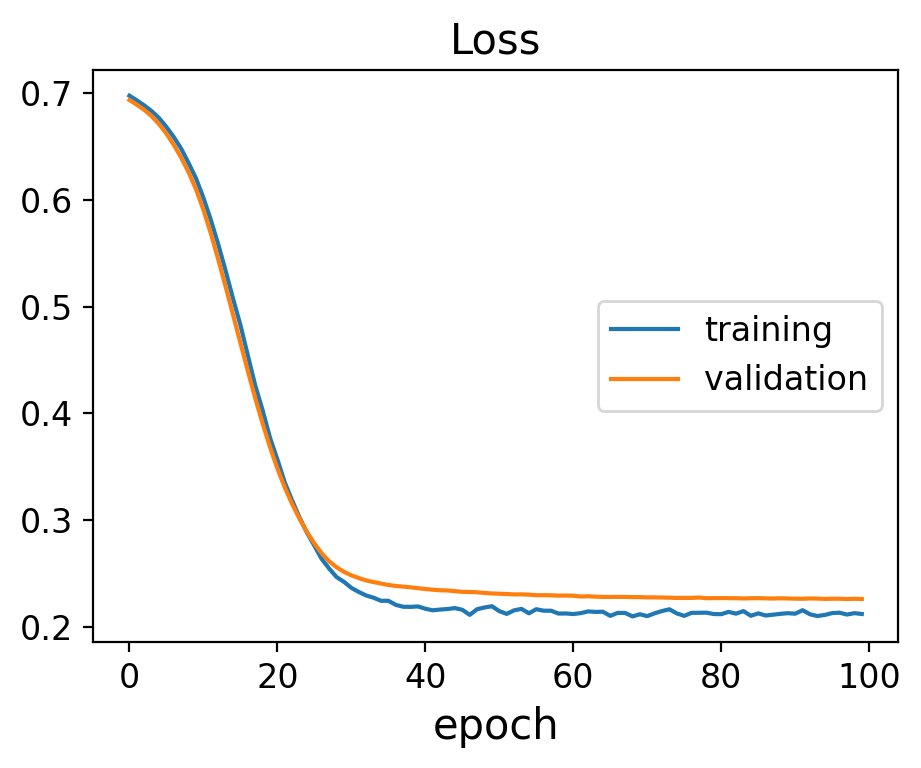

Loss
	training         	 (min:    0.210, max:    0.698, cur:    0.212)
	validation       	 (min:    0.226, max:    0.694, cur:    0.226)
Epoch 99, Loss: 0.2679268419742584


loss,████▇▇▆▆▅▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█████▆▆▅▅▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.21194
val_loss,0.22594


MLP(
  (MLP): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.1, inplace=False)
    (5): Linear(in_features=16, out_features=16, bias=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [26]:
train(n_epochs, hidden_dims, hidden_layers, lr)

Sweep using wandb

In [ ]:
sweep_config = {
    "method": "grid",
    "metric": {
        "name": "val_loss",
        "goal": "minimize"   
    },
    "parameters": {
        "optimizer": {
            "values": ["adam", "sgd"],
        },
        "n_epochs": {
            "values": [16, 32, 64, 100],
        },
        "hidden_layers": {
            "values": [1, 2, 3, 4],
        },
        "hidden_dims": {
            "values": [8, 16, 32, 64],
        },
        "lr": {
            "values": [0.1, 0.01, 0.001, 0.0001],
        },
    }
}

In [ ]:
import pprint
pprint.pprint(sweep_config)

{'method': 'grid',
 'metric': {'goal': 'minimize', 'name': 'val_loss'},
 'parameters': {'hidden_dims': {'values': [8, 16, 32, 64]},
                'hidden_layers': {'values': [1, 2, 3, 4]},
                'lr': {'values': [0.1, 0.01, 0.001, 0.0001]},
                'n_epochs': {'values': [16, 32, 64, 100]},
                'optimizer': {'values': ['adam', 'sgd']}}}


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="phys805")

In [ ]:
def train 

#### Using wandb

Skip this for now, but if you have time once you finish this notebook, try connecting the notebook to Wandb to have the option of tracking your runs: 
- https://docs.wandb.ai/guides/track/jupyter/ 

In [ ]:
wandb.init(
    project="mlphysics_course",
    config={
        "architecture": "MLP",
        "dataset": "2D Gaussians",
        "lr": lr,
        "epochs": n_epochs,
        "hidden_dims": hidden_dims,
        "hidden_layers": hidden_layers
    },
)

<a name='section_5'></a>
<h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #1f77b4">5. Evaluating model performance</h2>

The loss alone might not be a very intuitive metric for understanding our model performance. Let's evaluate the model on our holdout test set and get some new metrics.

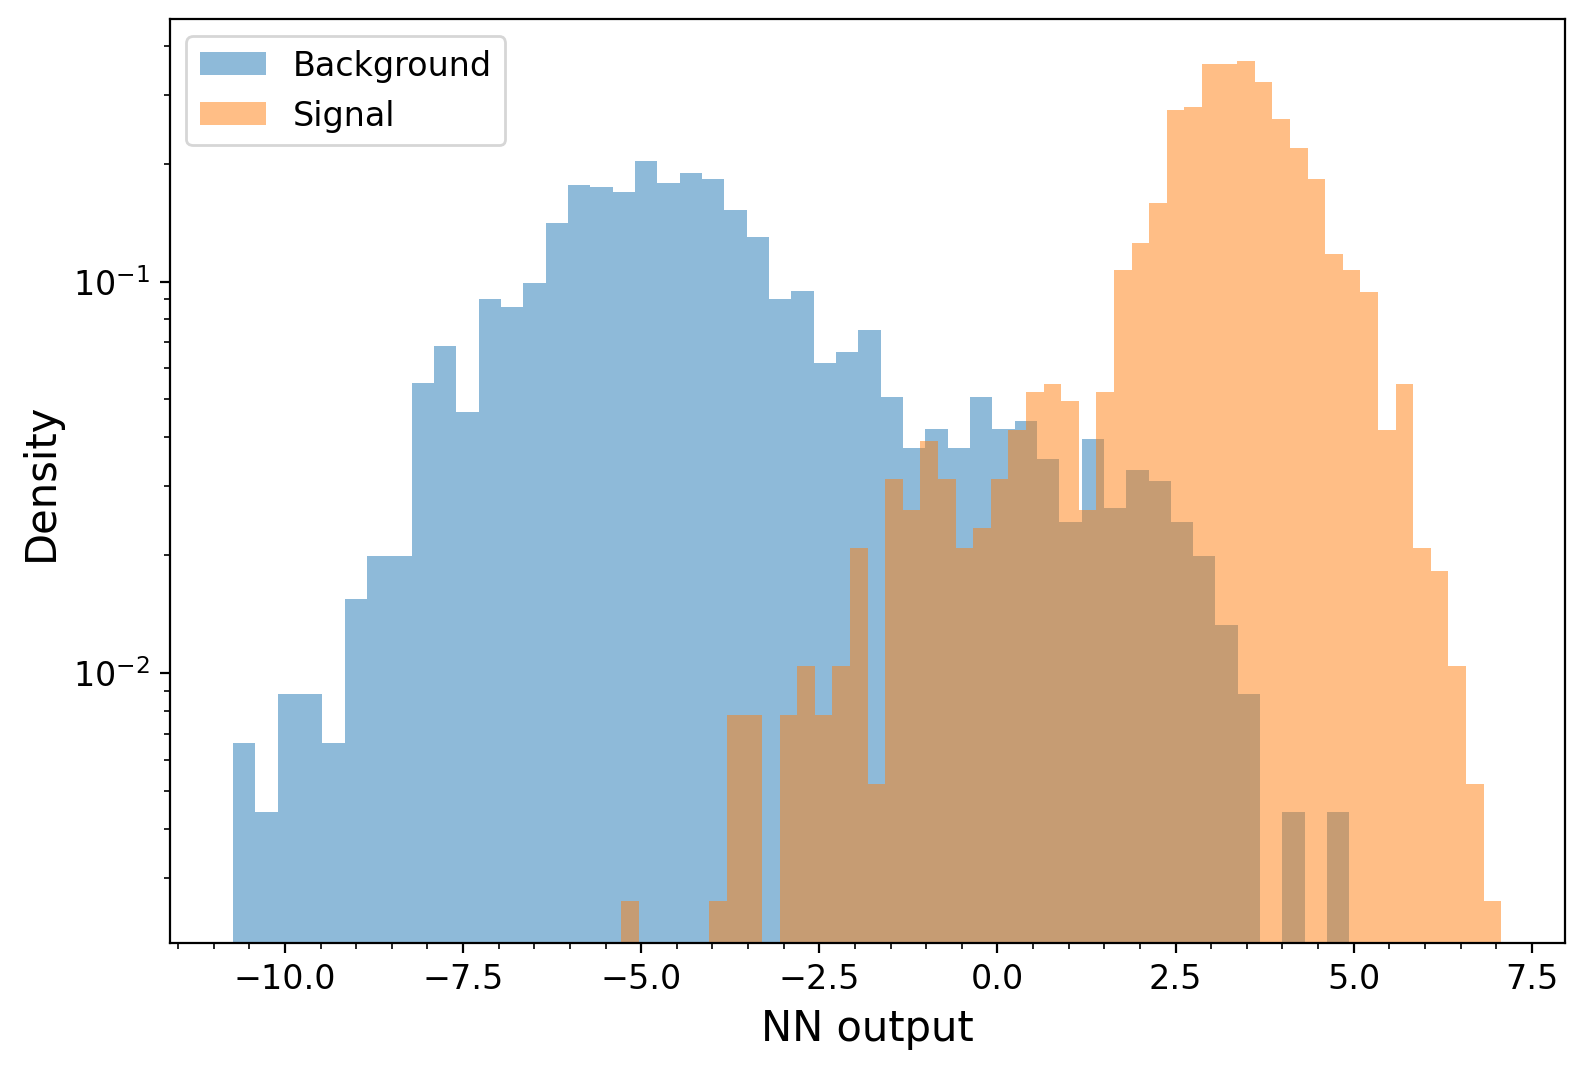

In [ ]:
torch.no_grad()
X_val_tensor, y_val_tensor = val_ds.tensors
NN_val = model(X_val_tensor)

NN_val_0 = NN_val[y_val_tensor.squeeze() == 0].detach().cpu().numpy()
NN_val_1 = NN_val[y_val_tensor.squeeze() == 1].detach().cpu().numpy()

plt.hist(NN_val_0, bins=50, density=True, alpha=0.5, label="Background")
plt.hist(NN_val_1, bins=50, density=True, alpha=0.5, label="Signal")
plt.xlabel("NN output")
plt.ylabel("Density")
plt.minorticks_on()
plt.legend()
plt.yscale("log")
plt.show()

In [143]:
### set the threshold for your NN score (what value makes sense here? can you plot values of your NN scores to understand their distribution?) 
threshold = 0 # <<<< FILL IN HERE

### test set 
model.eval()
test_loss, test_acc, count = 0.0, 0.0, 0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        
        ### Move the batch onto the GPU, if present
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
    
        out = model(x_batch)
        loss = loss_fn(out, y_batch)
        test_loss += loss.item() * x_batch.size(0)
        test_acc  += (torch.sigmoid(out) > threshold).float().eq(y_batch).float().mean().item() * x_batch.size(0)
        count += x_batch.size(0)
        
print(f"Average test loss: {test_loss/count:.4f} | Test accuracy: {test_acc/count:.3f}")

Average test loss: 0.1877 | Test accuracy: 0.503


### Further exercises:
- Try modifying the hidden size and number of MLP layers, to see the effect on performance
- Try increasing the dataset size
- Try different learning rates
- What's the effect of changing your batch size?
- Try adding dropout
- Try making the task harder by making the Gaussians overlap and/or shifting their positions. Where does your model start to break down?
- Can you track an "accuracy" metric alongside the loss in your live tracking plots?
- Can you track your runs on Wandb? 
- What is a simple baseline you could define here to get context for how well your model is doing? Implement this and use it as a comparison.
- Can you visualize the decision boundary in parameter space?